# 目录
[1. 数据集简介](#1)<br>
[2. 数据标注](#2)<br>
[3. 模型介绍](#3)<br>
[4. 构建模型](#4)<br> 
&nbsp;&nbsp;&nbsp;&nbsp;[4.1 YOLOv4网络结构](#4.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[4.2 模型训练函数](#4.2)<br>
[5. 模型训练](#5)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[5.1 加载数据](#5.1)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[5.2 冻结主干网络](#5.2)<br>
&nbsp;&nbsp;&nbsp;&nbsp;[5.3 解冻主干网络](#5.3)<br>
[6. 口罩检测效果](#6)<br>
[7. 总结](#7)<br>



<div id="1"></div>
# 1 数据集简介

本案例中使用的口罩数据集大小为790MB，共包含1600张图像，分为训练集和测试集。其中训练集中有1200张图像，600张佩戴口罩，600张未佩戴口罩；测试集有400张图像，200张佩戴口罩，200张未佩戴口罩。每张图像的像素大小不一致，图像均来源于生活场景。

数据来源主要为在百度和谷歌中，搜索关键词“口罩”、“隔离病房”、“医院监控”，并爬取相关图像。图像已标注了人脸是否佩戴口罩，并注明了检测框位置。

![png](http://cookdata.cn/media/note_images/口罩数据集_1604592329855_5d14.jpg)

<div id="2"></div>
# 2 数据标注

YOLOv4是监督学习算法，训练监督学习算法需要大量标注的数据集。数据标注是耗时耗力的工作，有便捷的工具协助可以节省很多时间精力。下面介绍图像标注工具labelImg。这款图像标注软件，常用于数据集的制作、标注等，便于创建自己的数据集，以进行深度学习训练。

labelImg只能用于标注矩形框，安装和使用都很简单。下图为训练集中的一张图像，四人中两个人佩戴口罩，标签为"mask"；两个人未佩戴口罩，标签为"nomask"。其标注信息可以直接转化成为xml文件，与PASCAL VOC以及ImageNet中使用的标注格式一致。

![png](http://cookdata.cn/media/note_images/标注_1604592346996_5d14.jpg)

接下来我们展示图像标注效果。首先加载口罩数据集`MaskDatasets.zip`，并解析文件。

In [ ]:
# 加载并解析数据集
!apt install unzip
!unzip MaskDatasets.zip

再加载对应的库和文件，以便后续调用。其中各代码文件通过定义函数，实现不同的功能。
+ `utils.py`：定义函数找出正确包含目标物体的检测框；
+ `CSPdarknet.py`：定义CSPDarknet53的网络结构，作为YOLOv4算法的主干网络；
+ `yolo4.py`：定义YOLOv4算法的网络结构；
+ `yolo_training.py`：文件定义了训练模型的步骤；
+ `yolo.py`：调用上述文件中的函数，训练模型从图像中检测目标物体的能力，优化模型参数。

In [34]:
# 加载python文件
cp yolo4.py ../
cp yolo_training.py ../
cp utils.py ../
cp CSPdarknet.py ../
cp yolo.py ../

# 加载库
from yolo4 import YoloBody
from yolo_training import YOLOLoss, Generator
import os
import time
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
import xml.etree.ElementTree as ET
import cv2
from matplotlib import pyplot as plt
from yolo import YOLO
from PIL import Image

从数据集中随机抽取一张图像，图像如下。

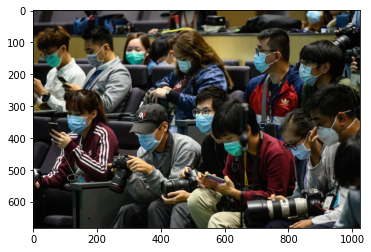

In [35]:
img = cv2.imread("/content/datasets/train/JPEGImages/train_1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

In [36]:
# 解析xml文件
def parse_rec(filename): 
    # 解析读取xml文件
    tree = ET.parse(filename) 
    objects = []
    
    # 提取xml文件中的信息
    for obj in tree.findall('object'):
        obj_struct = {}
        # name: 标签； bbox: 标注框
        obj_struct['name'] = obj.find('name').text
        obj_struct['pose'] = obj.find('pose').text
        obj_struct['truncated'] = int(obj.find('truncated').text)
        obj_struct['difficult'] = int(obj.find('difficult').text)
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(bbox.find('xmin').text),
        int(bbox.find('ymin').text),
        int(bbox.find('xmax').text),
        int(bbox.find('ymax').text)]
        objects.append(obj_struct)
    return objects

读取上图对应的标注文件，打印xml文件中的信息。每一行代表图像中一个标注矩形框的信息。如第一行表示该矩形框内的人脸带有口罩，并输出矩形框对角两点的坐标。

In [37]:
# 读取xml文件
path_xml = "/content/datasets/train/Annotations/train_1.xml"
obj = parse_rec(path_xml)
# 打印xml文件中的信息
for i in range(len(obj)):
    print(obj[i])

{'name': 'mask', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'bbox': [22, 104, 106, 183]}
{'name': 'mask', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'bbox': [161, 100, 237, 176]}
{'name': 'mask', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'bbox': [287, 105, 357, 173]}
{'name': 'mask', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'bbox': [384, 140, 447, 187]}
{'name': 'mask', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'bbox': [436, 133, 500, 200]}
{'name': 'mask', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'bbox': [692, 102, 754, 198]}
{'name': 'mask', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'bbox': [830, 152, 924, 241]}
{'name': 'mask', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'bbox': [878, 313, 983, 426]}
{'name': 'mask', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'bbox': [785, 395, 871, 472]}
{'name': 'mask', 'pose': 'Unspecified', 'truncated': 0, 'difficult': 0, 'bbox': [58

通过函数，将矩形框画在图像中，直观展示标注后的图像。

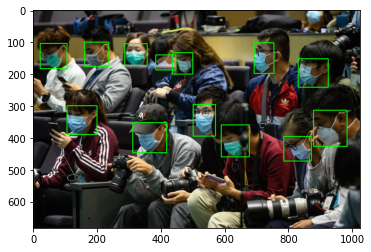

In [38]:
img = cv2.imread("/content/datasets/train/JPEGImages/train_1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
for i in range(len(obj)):
    #  x1,y1,x2,y2 : 标注框在图像中的坐标
    x1, y1, x2, y2= [int(i) for i in obj[i]["bbox"]]
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
plt.imshow(img)
plt.show()

<div id="3"></div>
# 3 模型介绍

本案例采用YOLOv4算法，实现口罩检测。YOLOv4算法基于YOLO算法进行了一系列的改进，包括数据处理、网络架构、网络训练、激活函数、损失函数，都进行了不同程度的优化，得到了更好的识别效果。YOLO系列是单阶段目标检测算法，即将提取候选区域和检测合二为一，直接得到物体检测的结果，因此其速度往往会更快一些。算法将物体检测作为回归问题求解，整合了整张图的信息来预测每个位置的物体。

YOLOv4算法的主干网络（backbone）为CSPDarknet53，主要作用为提取输入图像的特征。在训练YOLOv4时，我们将直接加载CSPDarknet53已经训练好的模型参数并进行微调，使得其更适合口罩检测任务。

Neck部分使用SPP，PAN网络结构，增大卷积核感受野，更好的利用backbone部分提取的图像特征信息。并且可以使网络适用于不同尺寸的目标检测。

Head部分与YOLOv3算法相同，主要目的是获取之前网络的输出信息，并做出预测。

![png](http://cookdata.cn/media/note_images/YOLOV4_1604592437290_5d14.jpg)

<div id="4"></div>
# 4 构建模型

获得标注好的数据集后，接下来开始构建YOLOv4网络。

<div id="4.1"></div>
## 4.1 YOLOv4网络结构

本案例采用的YOLOv4网络结构首先调用Darknet53网络，并删除全连接层，提取输入图像的特征信息；再将其输入SPP网络结构中，利用不同大小的池化核进行池化；之后进行卷积和上采样，最终获得YOLOv4的输出数据。

In [ ]:
class Yolo_Body(nn.Module):
    def __init__(self, num_anchors, num_classes):
        super(YoloBody, self).__init__()
        #  主干网络（backbone）：Darknet53网络
        self.backbone = darknet53(None)

        # 三次卷积块
        self.conv1 = make_three_conv([512,1024],1024)
        
        # SPP结构，利用不同大小的池化核进行池化；池化后堆叠
        self.SPP = SpatialPyramidPooling()
        self.conv2 = make_three_conv([512,1024],2048)

        # 卷积 + 上采样
        self.upsample1 = Upsample(512,256)
        self.conv_for_P4 = conv2d(512,256,1)
        # 五次卷积块
        self.make_five_conv1 = make_five_conv([256, 512],512)

        # 卷积 + 上采样
        self.upsample2 = Upsample(256,128)
        self.conv_for_P3 = conv2d(256,128,1)
        self.make_five_conv2 = make_five_conv([128, 256],256)
        final_out_filter2 = num_anchors * (5 + num_classes)
        self.yolo_head3 = yolo_head([256, final_out_filter2],128)

        # 卷积
        self.down_sample1 = conv2d(128,256,3,stride=2)
        self.make_five_conv3 = make_five_conv([256, 512],512)
        final_out_filter1 =  num_anchors * (5 + num_classes)
        self.yolo_head2 = yolo_head([512, final_out_filter1],256)

        # 卷积
        self.down_sample2 = conv2d(256,512,3,stride=2)
        self.make_five_conv4 = make_five_conv([512, 1024],1024)
        final_out_filter0 =  num_anchors * (5 + num_classes)
        self.yolo_head1 = yolo_head([1024, final_out_filter0],512)

    # 前向传播过程
    def forward(self, x):
        x2, x1, x0 = self.backbone(x)

        P5 = self.conv1(x0)
        P5 = self.SPP(P5)
        P5 = self.conv2(P5)

        P5_upsample = self.upsample1(P5)
        P4 = self.conv_for_P4(x1)
        P4 = torch.cat([P4,P5_upsample],axis=1)
        P4 = self.make_five_conv1(P4)

        P4_upsample = self.upsample2(P4)
        P3 = self.conv_for_P3(x2)
        P3 = torch.cat([P3,P4_upsample],axis=1)
        P3 = self.make_five_conv2(P3)

        P3_downsample = self.down_sample1(P3)
        P4 = torch.cat([P3_downsample,P4],axis=1)
        P4 = self.make_five_conv3(P4)

        P4_downsample = self.down_sample2(P4)
        P5 = torch.cat([P4_downsample,P5],axis=1)
        P5 = self.make_five_conv4(P5)
        
        # 输出数据
        out2 = self.yolo_head3(P3)
        out1 = self.yolo_head2(P4)
        out0 = self.yolo_head1(P5)
    
        return out0, out1, out2

<div id="4.2"></div>
## 4.2 模型训练函数

构造好YOLOv4模型的网络结构后，我们可以编写函数，将数据集放入YOLOv4模型进行训练。

首先加载数据，获取YOLOv4先验框的数据，以及人脸是否佩戴口罩的类别：佩戴口罩（mask）、不佩戴口罩（nomask）。

In [39]:
# 加载是否佩戴口罩的数据
def get_classes(classes_path):
    with open(classes_path) as f:
        class_names = f.readlines()
    class_names = [c.strip() for c in class_names]
    return class_names

# 加载YOLOv4先验框
def get_anchors(anchors_path):
    with open(anchors_path) as f:
        anchors = f.readline()
    anchors = [float(x) for x in anchors.split(',')]
    return np.array(anchors).reshape([-1,3,2])[::-1,:,:]

已有模型和数据，还需要函数将数据集放入模型训练。我们编写`fit_one_epoch`，规定模型训练一个epoch的流程，一个epoch即所有训练样本训练一次。

In [41]:
#   训练一个epoch
def fit_one_epoch(net, yolo_losses, epoch, epoch_size, epoch_size_val, gen,genval, Epoch, cuda, optimizer, lr_scheduler):
    # 损失值
    total_loss = 0
    val_loss = 0
    
    # 打印出损失值、训练进度的信息
    print('\n' + '-' * 10 + 'Train one epoch.' + '-' * 10)
    print('Epoch:'+ str(epoch+1) + '/' + str(Epoch))
    print('Start Training.')
    
    # 调用YoloV4模型训练数据集
    net.train()
    for iteration in range(epoch_size):
        start_time = time.time()
        # 加载图像及标注数据
        images, targets = next(gen)
        with torch.no_grad():
            if cuda:
                images = Variable(torch.from_numpy(images).type(torch.FloatTensor)).cuda()
                targets = [Variable(torch.from_numpy(ann).type(torch.FloatTensor)) for ann in targets]
            else:
                images = Variable(torch.from_numpy(images).type(torch.FloatTensor))
                targets = [Variable(torch.from_numpy(ann).type(torch.FloatTensor)) for ann in targets]
        
        # 设定优化函数初始值
        optimizer.zero_grad()
        outputs = net(images)
        
        # 记录每个步骤的损失
        losses = []
        for i in range(3):
            loss_item = yolo_losses[i](outputs[i], targets)
            losses.append(loss_item[0])
        loss = sum(losses)
        loss.backward()
        
        # 参数优化
        optimizer.step()
        lr_scheduler.step()
        
        # 计算总损失
        total_loss += loss
        waste_time = time.time() - start_time
        if iteration == 0 or (iteration+1) % 40 == 0:
            print('step:' + str(iteration+1) + '/' + str(epoch_size) + ' || Total Loss: %.4f || %.4fs/step' % (total_loss/(iteration+1), waste_time))
   
    # 打印训练结束、总损失值等信息
    print('Finish Training.')
    print('Total Loss: %.4f || Val Loss: %.4f ' % (total_loss/(epoch_size+1), val_loss/(epoch_size_val+1)))
    
    # 返回损失值
    return total_loss/(epoch_size+1), val_loss/(epoch_size_val+1)

<div id="5"></div>
# 5 模型训练

<div id="5.1"></div>
## 5.1 加载数据

构建好上述函数后，现在可以进行模型训练。首先加载相关数据。

In [42]:
# 图像输入像素大小
input_shape = (608, 608)

# 是否使用GPU训练
Cuda = True
smoooth_label = 0.03
Cosine_lr = True
mosaic = True

# 获得训练集和验证集的标注信息
train_annotation_path = '/content/mask_train.txt'
val_annotation_path = '/content/mask_val.txt'
with open(train_annotation_path) as f:
    train_lines = f.readlines()
with open(val_annotation_path) as f:
    val_lines = f.readlines()
num_train = len(train_lines)
num_val = len(val_lines)

#  获得先验框、是否佩戴口罩的类别
anchors_path = '/content/yolo_anchors.txt'
classes_path = '/content/mask_classes.txt'   
class_names = get_classes(classes_path)
anchors = get_anchors(anchors_path)
num_classes = len(class_names)

之后需要加载预训练模型，通过加载预训练模型，能够加快YOLOv4模型训练的速度，更快得到更好的训练效果。

In [43]:
# 创建模型
model = YoloBody(len(anchors[0]), num_classes)

# 加载预训练模型
model_path = "/content/yolov4_maskdetect_weights1.pth"
print('Loading pretrained model weights.')
model_dict = model.state_dict()
pretrained_dict = torch.load(model_path)
pretrained_dict = {k: v for k, v in pretrained_dict.items() if np.shape(model_dict[k]) ==  np.shape(v)}
model_dict.update(pretrained_dict)
model.load_state_dict(model_dict)
print('Finished!')

# 用多个GPU加速训练
if Cuda:
    net = torch.nn.DataParallel(model)
    cudnn.benchmark = True
    net = net.cuda()

# 获取损失值
yolo_losses = []
for i in range(3):
    yolo_losses.append(YOLOLoss(np.reshape(anchors, [-1,2]), num_classes, \
                                (input_shape[1], input_shape[0]), smoooth_label, Cuda))

Loading pretrained model weights.
Finished!


<div id="5.2"></div>
## 5.2 冻结主干网络

读取预训练模型，在自己的数据集上进行迁移学习的时候，训练一般分为两阶段。为了不破坏backbone层的提取能力，第一阶段需要先冻结backbone层结构，只对后面的网络进行微调。第二阶段再解冻backbone层，继续进行参数训练。

首先冻结backbone层结构，并进行5个epoch的训练。

In [44]:
# 冻结backbone训练

# 学习率、训练次数等参数
lr = 1e-3
Batch_size = 4
Init_Epoch = 0
Freeze_Epoch = 5
total_loss_list = []

# 优化器选择
optimizer = optim.Adam(net.parameters(), lr, weight_decay=5e-4)
if Cosine_lr:
    lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-5)
else:
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# 进行Mosaic数据增强
gen = Generator(Batch_size, train_lines, (input_shape[0], input_shape[1])).generate(mosaic = mosaic)
gen_val = Generator(Batch_size, val_lines, (input_shape[0], input_shape[1])).generate(mosaic = False)

# 一次训练的大小
epoch_size = int(max(1, num_train//Batch_size//2.5)) if mosaic else max(1, num_train//Batch_size)
epoch_size_val = num_val//Batch_size
for param in model.backbone.parameters():
    param.requires_grad = False

best_loss = 99999999.0
best_model_weights = copy.deepcopy(net.state_dict())

# 模型训练
for epoch in range(Init_Epoch, Freeze_Epoch):
    # 进行一个epoch训练
    total_loss, val_loss = fit_one_epoch(net, yolo_losses, epoch, epoch_size, epoch_size_val, gen, gen_val, 
                                         Freeze_Epoch, Cuda, optimizer, lr_scheduler)
    # 总损失值，决定是否优化参数
    if total_loss < best_loss:
        best_loss = total_loss
        best_model_weights = copy.deepcopy(model.state_dict())
    total_loss_list.append(str(total_loss.item()))



----------Train one epoch.----------
Epoch:1/5
Start Training.
step:1/120 || Total Loss: 18.7028 || 11.8015s/step
step:40/120 || Total Loss: 24.1529 || 3.0553s/step
step:80/120 || Total Loss: 21.0102 || 1.7426s/step
step:120/120 || Total Loss: 19.4187 || 1.8619s/step
Finish Training.
Total Loss: 19.2583 || Val Loss: 0.0000 

----------Train one epoch.----------
Epoch:2/5
Start Training.
step:1/120 || Total Loss: 4.1509 || 1.7919s/step
step:40/120 || Total Loss: 20.9038 || 1.9097s/step
step:80/120 || Total Loss: 17.3937 || 2.8208s/step
step:120/120 || Total Loss: 16.1631 || 2.4072s/step
Finish Training.
Total Loss: 16.0295 || Val Loss: 0.0000 

----------Train one epoch.----------
Epoch:3/5
Start Training.
step:1/120 || Total Loss: 7.5487 || 1.8501s/step


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


step:40/120 || Total Loss: 18.4463 || 2.9412s/step
step:80/120 || Total Loss: 16.7276 || 1.8917s/step
step:120/120 || Total Loss: 17.1671 || 1.8622s/step
Finish Training.
Total Loss: 17.0252 || Val Loss: 0.0000 

----------Train one epoch.----------
Epoch:4/5
Start Training.
step:1/120 || Total Loss: 8.3914 || 1.8922s/step
step:40/120 || Total Loss: 16.7259 || 1.8449s/step
step:80/120 || Total Loss: 16.8205 || 3.0116s/step
step:120/120 || Total Loss: 17.8067 || 2.0069s/step
Finish Training.
Total Loss: 17.6596 || Val Loss: 0.0000 

----------Train one epoch.----------
Epoch:5/5
Start Training.
step:1/120 || Total Loss: 18.6126 || 2.0951s/step
step:40/120 || Total Loss: 15.9737 || 2.2926s/step
step:80/120 || Total Loss: 16.8613 || 1.9486s/step
step:120/120 || Total Loss: 15.2460 || 1.9692s/step
Finish Training.
Total Loss: 15.1200 || Val Loss: 0.0000 


<div id="5.3"></div>
## 5.3 解冻主干网络

为提高模型在口罩数据集上的训练精度，我们解冻主干网络后，再次进行5个epoch的训练。

In [46]:
#   解冻backbone后训练
lr = 1e-4
Batch_size = 2
# 解冻后训练5个epoch
Unfreeze_Epoch = 10
Freeze_Epoch = 5

# 选择优化器
optimizer = optim.Adam(net.parameters(), lr, weight_decay=5e-4)
if Cosine_lr:
    lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=1e-5)
else:
    lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

# 数据增强
gen = Generator(Batch_size, train_lines, (input_shape[0], input_shape[1])).generate(mosaic = mosaic)
gen_val = Generator(Batch_size, val_lines, (input_shape[0], input_shape[1])).generate(mosaic = False)

# 一次训练的图像数量
epoch_size = int(max(1, num_train//Batch_size//2.5)) if mosaic else max(1, num_train//Batch_size)
epoch_size_val = num_val//Batch_size
for param in model.backbone.parameters():
    param.requires_grad = True

# 解冻后训练epoch
for epoch in range(Freeze_Epoch, Unfreeze_Epoch):
    total_loss, val_loss = fit_one_epoch(net, yolo_losses, epoch, epoch_size, epoch_size_val, gen, gen_val, 
                                         Unfreeze_Epoch, Cuda, optimizer, lr_scheduler)
    # 决定是否优化参数
    if total_loss < best_loss:
        best_loss = total_loss
        best_model_weights = copy.deepcopy(model.state_dict())
    
    # 保存损失值
    total_loss_list.append(str(total_loss.item()))

# 保存训练结果
torch.save(best_model_weights, '/content/yolov4_maskdetect_weights1.pth')


----------Train one epoch.----------
Epoch:6/10
Start Training.
step:1/240 || Total Loss: 5.7762 || 14.3340s/step
step:40/240 || Total Loss: 14.7843 || 1.5463s/step
step:80/240 || Total Loss: 14.3918 || 1.2994s/step
step:120/240 || Total Loss: 12.8509 || 1.3953s/step


/usr/local/lib/python3.6/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


step:160/240 || Total Loss: 11.9928 || 1.4618s/step
step:200/240 || Total Loss: 12.2974 || 1.5007s/step
step:240/240 || Total Loss: 12.4371 || 1.4757s/step
Finish Training.
Total Loss: 12.3855 || Val Loss: 0.0000 

----------Train one epoch.----------
Epoch:7/10
Start Training.
step:1/240 || Total Loss: 7.0205 || 1.3318s/step
step:40/240 || Total Loss: 12.8778 || 1.4566s/step
step:80/240 || Total Loss: 11.0449 || 2.0057s/step
step:120/240 || Total Loss: 10.8346 || 1.4081s/step
step:160/240 || Total Loss: 11.8006 || 1.6266s/step
step:200/240 || Total Loss: 11.3232 || 1.3014s/step
step:240/240 || Total Loss: 11.2475 || 1.5938s/step
Finish Training.
Total Loss: 11.2009 || Val Loss: 0.0000 

----------Train one epoch.----------
Epoch:8/10
Start Training.
step:1/240 || Total Loss: 10.3564 || 1.4386s/step
step:40/240 || Total Loss: 15.7419 || 1.3513s/step
step:80/240 || Total Loss: 16.5164 || 1.6682s/step
step:120/240 || Total Loss: 15.6012 || 1.4547s/step
step:160/240 || Total Loss: 15.4745

<div id="6"></div>
# 6 口罩检测效果

下图展示了训练过程中损失值的变化。可以看到随着训练次数的增加，损失值总体在不断降低，证明模型检测的精度不断增加。

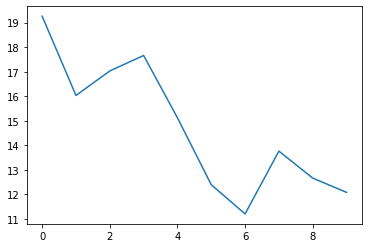

In [54]:
# 损失值变化
plt.plot(list(map(lambda x:round(float(x) ,2),total_loss_list)))
plt.show()

为了直观展示出模型检测口罩的能力，我们调用模型检测一张图像，观察其检测结果。

首先定义训练一张图像的函数，并保存训练结果。

下图是需要进行检测的图像，图像佩戴口罩和未佩戴口罩的人。

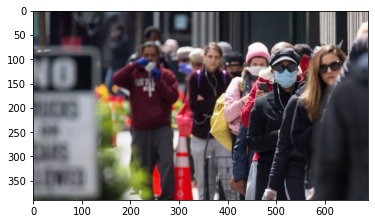

In [63]:
img = plt.imread("/content/test.jpg")
plt.imshow(img)
plt.show()

调用函数进行检测，并输出检测结果。如下所示，模型判断图像中能够清楚识别的四人中，两人佩戴口罩，两人未佩戴口罩，且输出了对应的概率。

In [64]:
img = Image.open("/content/test.jpg")
yolo = YOLO()
r_image = yolo.detect_image(img)

Loading pretrained weights.
Finish loading!
/content/yolov4_maskdetect_weights1.pth model, anchors, and classes loaded.
(4, 4)
b'mask: 0.99'
b'mask: 0.94'
b'nomask: 0.98'
b'nomask: 0.95'


展示检测后的图像，方便人们更加简单直观地看到模型检测结果。可以看到模型判断的结果正确，能够准确分辨出人们是否佩戴了口罩。

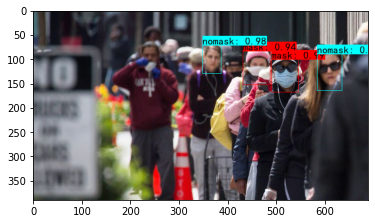

In [65]:
plt.imshow(r_image)
plt.show()

<div id="7"></div>
# 7 总结

在本案例中，我们使用YOLOv4模型检测人脸是否佩戴口罩。因为图像是从网络上收集得到，并没有进行标注。我们首先介绍如何使用labelImg软件标注图像。再介绍了YOLOv4模型的网络架构，包括其主干网络（backbone）、head、neck部分。接着考虑到模型加载了预训练的参数，需要进行迁移学习，我们分为两阶段：冻结及解冻backbone部分，分别训练模型。最后检测模型的检测效果，可以看到模型检测效果良好，可以准确地识别出人脸是否佩戴口罩。